Este agarra los audio segments de audio_segments/, los procesa, y carga los spectrograms finales a spect/

In [8]:
import os, sys
import pandas as pd
import numpy as np
import torch
from PIL import Image

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils.data_processing import reduce_noise_seg, create_single_spectrogram, save_test_audio, plot_summary, load_audio_segments_from_disk, clean_dir

In [ ]:
def create_spectrograms_from_segments(segments, spectrogram_dir, output_csv_path, 
                                    test_audios_dir=None, mels=224, hoplen=512, 
                                    nfft=2048, noise_reduce=False):
    """
    Create spectrograms from extracted audio segments.
    
    Args:
        segments (list): List of segment dictionaries from extract_audio_segments
        spectrogram_dir (str): Directory to save spectrogram images
        output_csv_path (str): Path to save the output CSV
        test_audios_dir (str, optional): Directory to save test audio samples
        mels (int): Number of mel bands for spectrogram
        hoplen (int): Hop length for spectrogram
        nfft (int): FFT window size
        noise_reduce (bool): Whether to apply noise reduction
        
    Returns:
        pd.DataFrame: DataFrame with spectrogram metadata
    """
    print(f"Creating spectrograms from {len(segments)} segments...")
    
    os.makedirs(spectrogram_dir, exist_ok=True)
    if test_audios_dir:
        os.makedirs(test_audios_dir, exist_ok=True)
    
    spectrogram_records = []
    saved_test_audios = 0
    skipped_count = 0
    
    for i, segment_info in enumerate(segments):
        # Apply noise reduction if requested
        if noise_reduce:
            segment_info['audio_data'] = reduce_noise_seg(
                segment_info['audio_data'], 
                srate=segment_info['sr'], 
                filename=segment_info['original_filename'], 
                class_id=segment_info['class_id']
            )
        
        # Create spectrogram
        record = create_single_spectrogram(segment_info, spectrogram_dir, mels, hoplen, nfft)
        
        if record is not None:
            # Save test audio if requested (first 10 only)
            if test_audios_dir and saved_test_audios < 10:
                save_test_audio(segment_info, test_audios_dir)
                saved_test_audios += 1
            
            spectrogram_records.append(record)
        else:
            skipped_count += 1
    
    # Create and save final DataFrame
    final_df = pd.DataFrame(spectrogram_records)
    final_df.to_csv(output_csv_path, index=False)
    
    # Print summary
    print(f"Spectrogram generation summary:")
    print(f"  Total processed: {len(segments)}")
    print(f"  Successfully created: {len(spectrogram_records)}")
    print(f"  Skipped due to errors: {skipped_count}")
    
    plot_summary(final_df, output_csv_path)
    return final_df

In [4]:
# Define Paths
# Input: Audio segments from AudioExtracting notebook
segments_dir = os.path.join('..', 'database', 'audio_segments')
segments_csv_path = os.path.join('..', 'database', 'meta', 'audio_segments.csv')

# Output: Spectrograms and metadata
spect_dir = os.path.join('..', 'database', 'spect')
output_csv = os.path.join('..', 'database', 'meta', 'final_spects.csv')
test_audios_dir = os.path.join('..', 'database', 'test_audios')

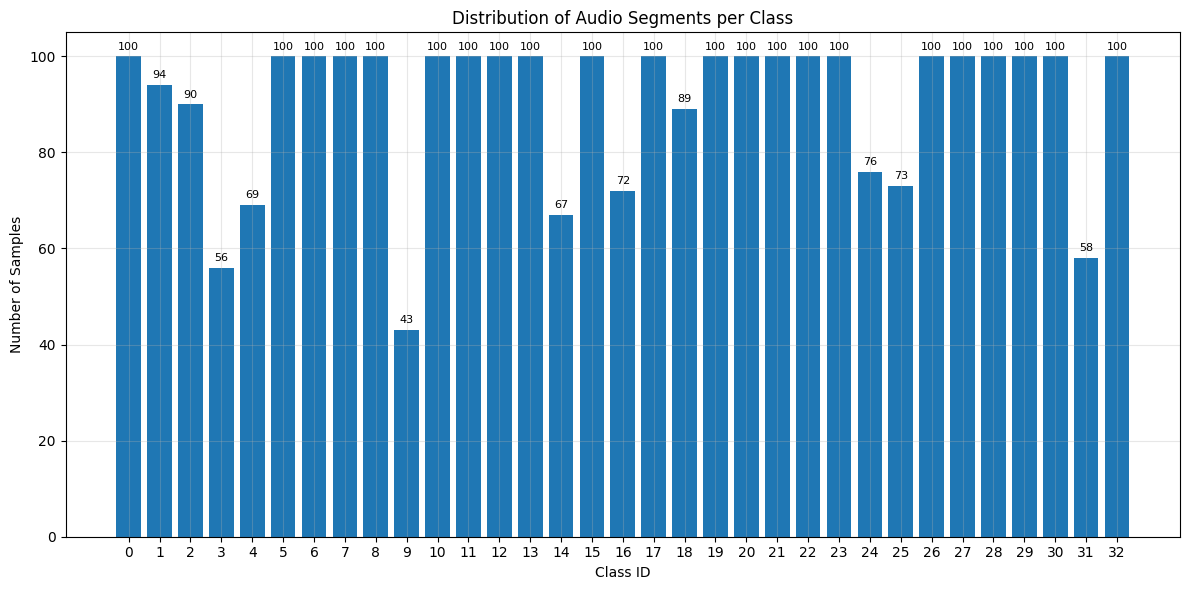

Total classes: 33
Total segments: 2987
Average segments per class: 90.5


In [11]:
# Load the segments CSV and plot distribution of samples per class
segments_df = pd.read_csv(segments_csv_path)

# Count samples per class
class_counts = segments_df['class_id'].value_counts().sort_index()

# Create the plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class ID')
plt.ylabel('Number of Samples')
plt.title('Distribution of Audio Segments per Class')
plt.xticks(class_counts.index)
plt.grid(True, alpha=0.3)

# Add value labels on top of bars
for i, v in enumerate(class_counts.values):
    plt.text(class_counts.index[i], v + 1, str(v), ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

print(f"Total classes: {len(class_counts)}")
print(f"Total segments: {len(segments_df)}")
print(f"Average segments per class: {len(segments_df) / len(class_counts):.1f}")

In [6]:
# Preview files in segments_dir
print(f"Checking directory: {segments_dir}")
if os.path.exists(segments_dir):
    files = os.listdir(segments_dir)
    print(f"Total files in segments_dir: {len(files)}")
    print("\nFirst 10 files:")
    for file in files[:10]:
        print(f"  {file}")
    if len(files) > 10:
        print("  ...")
else:
    print("Directory does not exist!")

Checking directory: ..\database\audio_segments
Total files in segments_dir: 2987

First 10 files:
  XC112710_0.wav
  XC112710_1.wav
  XC112710_2.wav
  XC112712_0.wav
  XC112712_1.wav
  XC112712_10.wav
  XC112712_11.wav
  XC112712_12.wav
  XC112712_13.wav
  XC112712_14.wav
  ...


In [ ]:
print("Loading audio segments from disk...")
segments = load_audio_segments_from_disk(segments_csv_path, segments_dir, sr=32000)

if not segments:
    print("No segments loaded! Make sure AudioExtracting notebook has been run first.")
else:
    print(f"Loaded {len(segments)} segments from disk")
    print(f"First segment keys: {list(segments[0].keys())}")

In [ ]:
clean_dir(spect_dir)
clean_dir(test_audios_dir)

print("Creating spectrograms from loaded segments...")
specs = create_spectrograms_from_segments(
    segments, spect_dir, output_csv, 
    test_audios_dir=test_audios_dir, 
    mels=224, hoplen=512, nfft=2048, 
    noise_reduce=False
)

print("Spectrogram generation complete!")

Aca veo los tamaños

In [12]:
import random
amount = 20

# List all PNG files in spect_dir
spect_files = [f for f in os.listdir(spect_dir) if f.endswith('.png')]

# Fetch random images
random_files = random.sample(spect_files, min(amount, len(spect_files)))

for fname in random_files:
    img_path = os.path.join(spect_dir, fname)
    img = Image.open(img_path)
    print(f"{fname}: {img.size}")

XC157210_1_1.png: (313, 224)
XC50969_1_1.png: (313, 224)
XC387953_0_0.png: (313, 224)
XC133617_2_2.png: (313, 224)
XC447911_2_2.png: (313, 224)
XC186385_2_2.png: (313, 224)
XC255550_9_9.png: (313, 224)
XC427432_1_1.png: (313, 224)
XC51744_2_2.png: (313, 224)
XC70535_12_12.png: (313, 224)
XC332738_0_0.png: (313, 224)
XC288055_3_3.png: (313, 224)
XC417122_1_1.png: (313, 224)
XC166047_1_1.png: (313, 224)
XC503481_0_0.png: (313, 224)
XC171686_1_1.png: (313, 224)
XC573792_0_0.png: (313, 224)
XC123670_7_7.png: (313, 224)
XC336416_1_1.png: (313, 224)
XC171689_0_0.png: (313, 224)


In [58]:
# Test SpecAugment on generated spectrograms
# sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils.specaugment import SpecAugment, get_recommended_params, visualize_specaugment, test_specaugment_on_random_spec

num_spects = len(spect_files)
print(f"Total spectrograms available: {num_spects}")

num_classes = len(class_counts)
print(f"Total classes available: {num_classes}")

samples_per_class = num_spects / num_classes
print(f"Average samples per class: {samples_per_class:.1f}")

# Get recommended parameters for your dataset
recommended_params = get_recommended_params(
    num_samples=num_spects,
    num_classes=num_classes,
    input_size=(224, 313)  # height, width
)

print("Recommended SpecAugment parameters for your dataset:")
for key, value in recommended_params.items():
    print(f"  {key}: {value}")

Total spectrograms available: 2987
Total classes available: 33
Average samples per class: 90.5
Recommended SpecAugment parameters for your dataset:
  time_mask_param: 39
  freq_mask_param: 14
  num_time_masks: 1
  num_freq_masks: 1
  mask_value: 0.0
  p: 0.8


Testing SpecAugment on random spectrogram...


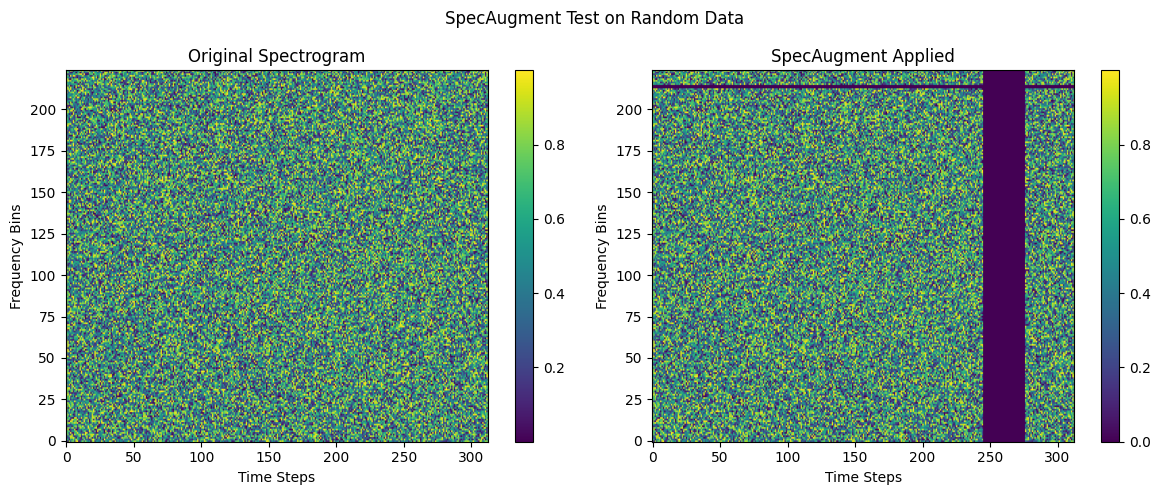

(tensor([[0.4281, 0.0178, 0.8301,  ..., 0.8390, 0.8060, 0.4758],
         [0.5720, 0.6132, 0.0562,  ..., 0.0088, 0.5880, 0.1080],
         [0.2020, 0.2656, 0.2650,  ..., 0.2516, 0.7007, 0.5371],
         ...,
         [0.2731, 0.1498, 0.2885,  ..., 0.0465, 0.7537, 0.9162],
         [0.7480, 0.7850, 0.2334,  ..., 0.1027, 0.9548, 0.7982],
         [0.5693, 0.5324, 0.2781,  ..., 0.9098, 0.2742, 0.2293]]),
 tensor([[0.4281, 0.0178, 0.8301,  ..., 0.8390, 0.8060, 0.4758],
         [0.5720, 0.6132, 0.0562,  ..., 0.0088, 0.5880, 0.1080],
         [0.2020, 0.2656, 0.2650,  ..., 0.2516, 0.7007, 0.5371],
         ...,
         [0.2731, 0.1498, 0.2885,  ..., 0.0465, 0.7537, 0.9162],
         [0.7480, 0.7850, 0.2334,  ..., 0.1027, 0.9548, 0.7982],
         [0.5693, 0.5324, 0.2781,  ..., 0.9098, 0.2742, 0.2293]]))

In [57]:
# Test SpecAugment on a random spectrogram
print("Testing SpecAugment on random spectrogram...")
test_specaugment_on_random_spec(shape=(224, 313), **recommended_params)


Testing SpecAugment on actual spectrograms...

Testing on XC112710_0_0.png


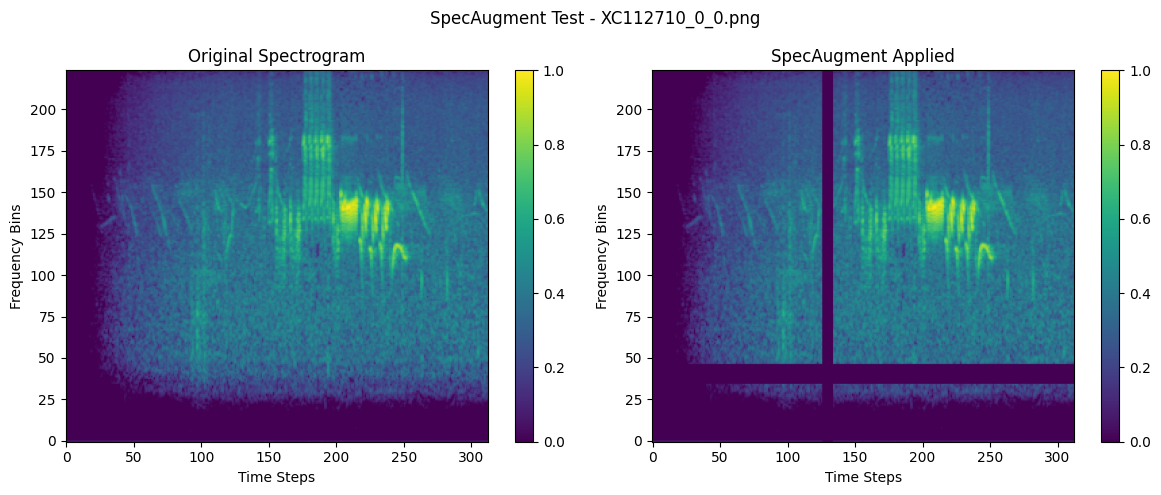


Testing on XC112710_1_1.png


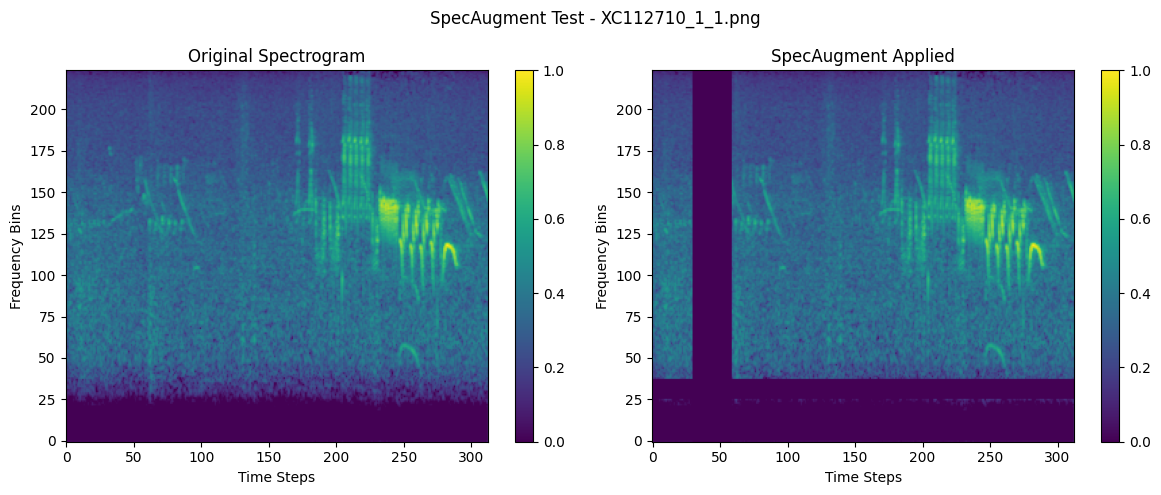


Testing on XC112710_2_2.png


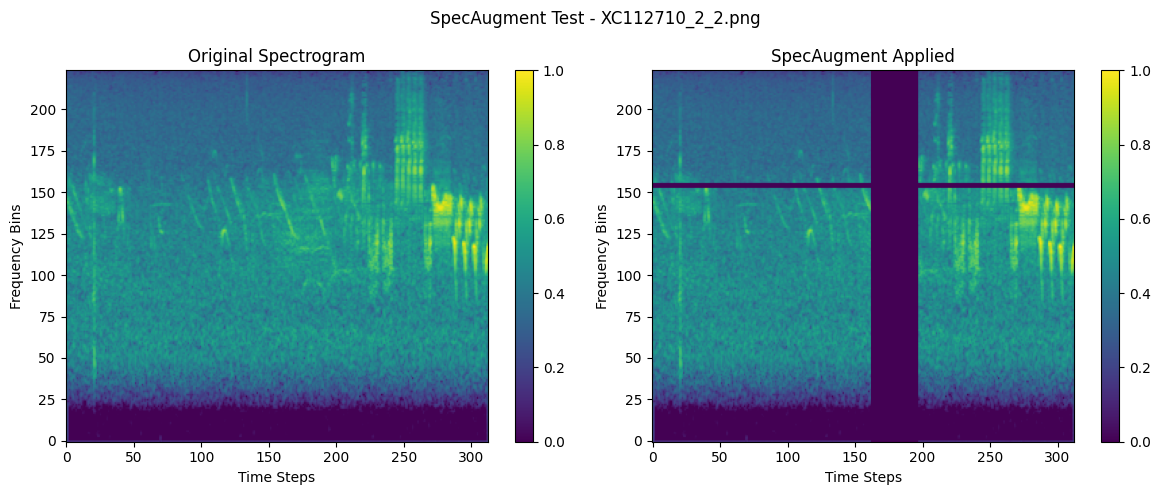

In [60]:
# Test SpecAugment on actual generated spectrograms
if len(specs) > 0:
    print(f"\nTesting SpecAugment on actual spectrograms...")
    
    # Load a few actual spectrograms for testing
    test_files = [f for f in os.listdir(spect_dir) if f.endswith('.png')][:3]
    
    for i, filename in enumerate(test_files):
        print(f"\nTesting on {filename}")
        
        # Load spectrogram
        img_path = os.path.join(spect_dir, filename)
        img = Image.open(img_path).convert('L')
        spec_array = np.array(img) / 255.0  # Normalize to 0-1
        spec_tensor = torch.tensor(spec_array, dtype=torch.float32)
        
        # Apply SpecAugment
        augmenter = SpecAugment(**recommended_params)
        augmented_spec = augmenter(spec_tensor)
        
        # Visualize
        visualize_specaugment(
            spec_tensor, 
            augmented_spec, 
            title=f"SpecAugment Test - {filename}"
        )
        
        if i >= 2:  # Limit to 3 examples
            break
else:
    print("No spectrograms available for testing. Run spectrogram generation first.")

Resetting ..\database\spect2 directory...
Resetting ..\database\test_audios2 directory...
Creating spectrograms from loaded segments...
Creating spectrograms from 2987 segments...


c:\Users\manue\miniconda3\envs\birds\Lib\site-packages\noisereduce\spectralgate\nonstationary.py:70: RuntimeWarning: invalid value encountered in divide
  sig_mult_above_thresh = (abs_sig_stft - sig_stft_smooth) / sig_stft_smooth


Error creating spectrogram for segment 0 of XC590621.wav: Audio buffer is not finite everywhere
Error creating spectrogram for segment 1 of XC590621.wav: Audio buffer is not finite everywhere


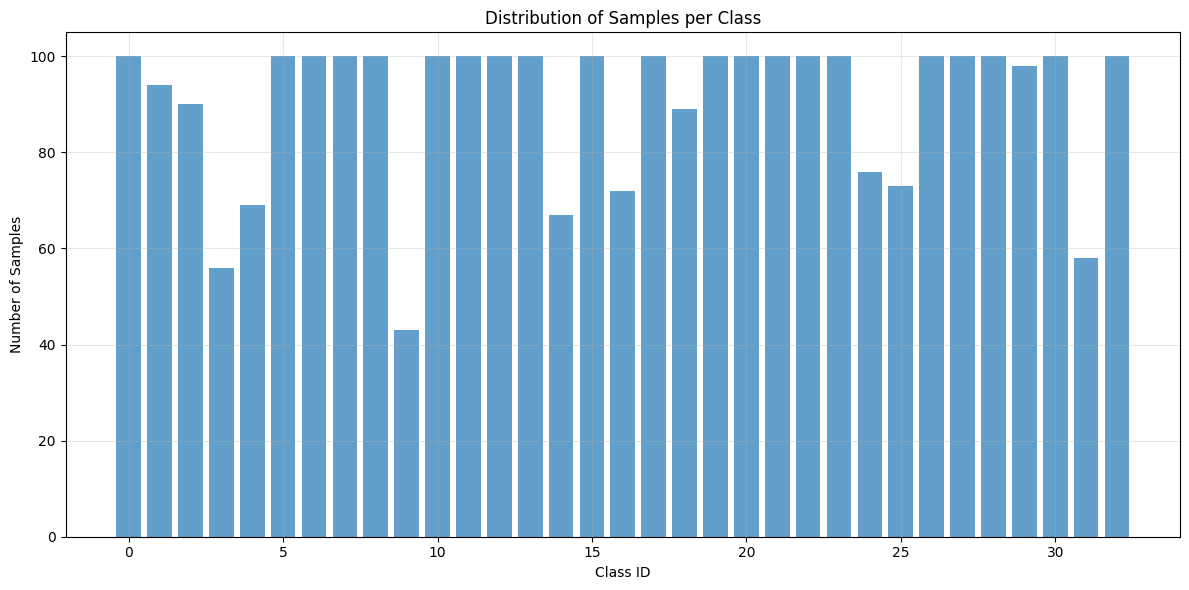

Spectrogram generation complete!


In [62]:
# Noise-Reduced Spectrogram Test
spect_dir2 = os.path.join('..', 'database', 'spect2')
output_csv2 = os.path.join('..', 'database', 'meta', 'final_spects2.csv')
test_audios_dir2 = os.path.join('..', 'database', 'test_audios2')

clean_dir(spect_dir2)
clean_dir(test_audios_dir2)

print("Creating spectrograms from loaded segments...")
specs = create_spectrograms_from_segments(
    segments, spect_dir2, output_csv2, 
    test_audios_dir=test_audios_dir2, 
    mels=224, hoplen=512, nfft=2048, 
    noise_reduce=True
)

print("Spectrogram generation complete!")